In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import pandas as pd

%matplotlib inline

In [2]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

lr = 0.001

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(3, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        self.pool2 = nn.MaxPool2d(3, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.pool3 = nn.AvgPool2d(3, stride=2)
        
        self.fc4 = nn.Linear(64 * 3 * 3, 10)
        

    def forward(self, x):
        activation_1 = F.relu(self.bn1(self.pool1(self.conv1(x))))
        activation_2 = F.relu(self.bn2(self.pool2(self.conv2(activation_1))))
        activation_3 = self.pool3(F.relu(self.conv3(activation_2)))
        activation_3 = activation_3.view(-1, 64 * 3 * 3)
        out = self.fc4(activation_3)
        # torch.sign(activation_1.view(-1, 32 * 15 * 15)), torch.sign(activation_2.view(-1, 32 * 7 * 7)), 
        return out, torch.sign(activation_3)
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): AvgPool2d (
  )
  (fc4): Linear (576 -> 10)
)


In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
if cuda:
    model.cuda()
    criterion.cuda()

In [10]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 20 * 11 / batchSize))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def nearest_neighbours_plot():
    SelectedImages = 0
    SelectedActivations = 0
    BestImages = torch.FloatTensor(batchSize, 11, 3, 32, 32).cuda()
    Distances = np.zeros([batchSize, 10])
    Distances.fill(np.inf)
    
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        dataVar, target = Variable(data), Variable(target)
        output, activations = model(dataVar)
        if batch_idx == 0:
            SelectedImages = data
            SelectedActivations = activations
        else:
            for SelecIndex in range(SelectedImages.size(0)):    
                for potentialNeighbour in range(activations.size(0)):
                    currentDistance = torch.abs(activations[potentialNeighbour] - SelectedActivations[SelecIndex]).sum().cpu().data.numpy()[0]
                    if currentDistance < Distances[SelecIndex].max():
                        # Update everything
                        for position in range(10):
                            if currentDistance < Distances[SelecIndex, position]:
                                Distances[SelecIndex, position:] = np.append(currentDistance, Distances[SelecIndex, position:9])
                                if position == 9:
                                    BestImages[SelecIndex, position] = data[potentialNeighbour].unsqueeze(0)
                                else:
                                    BestImages[SelecIndex, position:] = torch.cat((data[potentialNeighbour].unsqueeze(0), BestImages[SelecIndex, position:10]))
                                break
                                    
            
            if batch_idx == 500:
                break
    for SelecIndex in range(SelectedImages.size(0)):
        BestImages[SelecIndex] = torch.cat((SelectedImages[SelecIndex].unsqueeze(0), BestImages[SelecIndex, :10]), 0)
    BestImages.resize_(batchSize * 11, 3, 32, 32)
    imshow(torchvision.utils.make_grid(BestImages.cpu(), nrow=11))
    print(Distances)

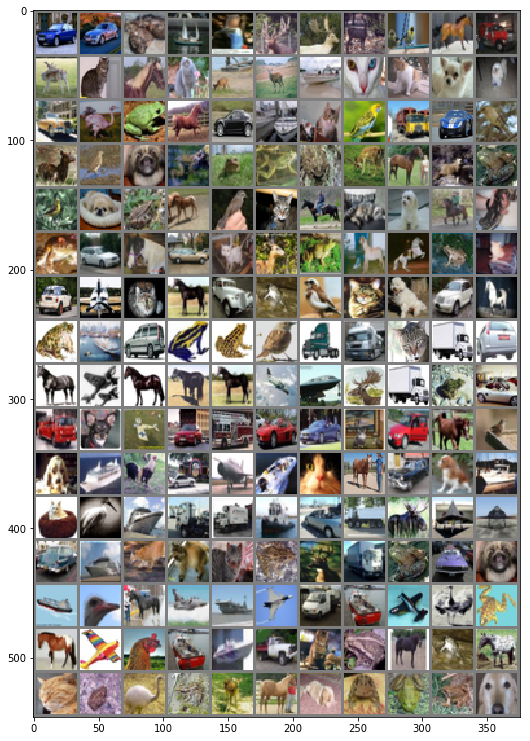

[[ 32.  34.  35.  36.  37.  37.  37.  37.  38.  38.]
 [ 40.  42.  43.  43.  43.  44.  44.  44.  45.  45.]
 [ 28.  29.  31.  32.  32.  32.  32.  33.  33.  33.]
 [ 37.  38.  38.  39.  39.  39.  41.  42.  43.  43.]
 [ 33.  34.  34.  34.  34.  34.  35.  35.  35.  35.]
 [ 37.  37.  37.  38.  39.  39.  40.  40.  40.  41.]
 [ 40.  40.  43.  43.  43.  44.  44.  44.  45.  45.]
 [ 35.  35.  35.  36.  36.  36.  36.  36.  36.  37.]
 [ 31.  31.  35.  35.  35.  36.  36.  36.  37.  37.]
 [ 49.  50.  50.  51.  51.  51.  52.  52.  53.  53.]
 [ 39.  41.  41.  42.  42.  42.  42.  42.  42.  42.]
 [ 36.  36.  37.  37.  37.  38.  38.  38.  39.  39.]
 [ 32.  32.  36.  36.  36.  37.  38.  38.  38.  39.]
 [ 34.  35.  37.  39.  40.  40.  40.  40.  40.  41.]
 [ 32.  32.  33.  34.  34.  35.  35.  35.  35.  36.]
 [ 52.  52.  53.  53.  53.  54.  54.  54.  55.  55.]]
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.271931
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.803101
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.614643
Train E

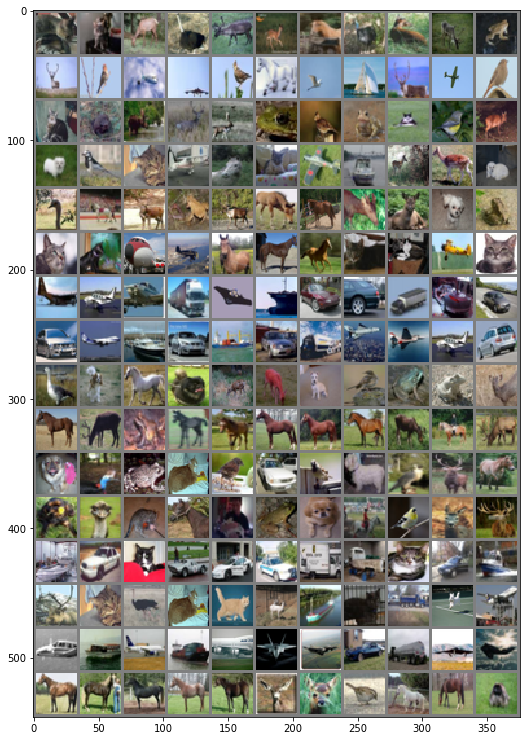

[[  2.   2.   2.   2.   2.   2.   2.   2.   3.   3.]
 [ 35.  35.  36.  37.  38.  40.  41.  41.  42.  42.]
 [  7.   8.   8.   8.   8.   8.   8.   8.   8.   8.]
 [  7.   8.   8.   8.   8.   9.   9.   9.   9.   9.]
 [ 20.  21.  21.  21.  22.  22.  22.  22.  22.  23.]
 [ 18.  18.  19.  19.  19.  19.  20.  20.  20.  20.]
 [ 20.  21.  22.  22.  23.  24.  24.  24.  25.  25.]
 [ 30.  30.  31.  31.  31.  32.  32.  32.  32.  32.]
 [ 11.  11.  11.  12.  12.  12.  12.  12.  12.  12.]
 [ 20.  21.  21.  21.  21.  22.  22.  22.  22.  22.]
 [ 10.  11.  11.  12.  12.  12.  12.  12.  12.  12.]
 [ 10.  11.  12.  12.  12.  12.  12.  13.  13.  13.]
 [ 21.  21.  21.  22.  22.  22.  23.  23.  23.  23.]
 [  7.   7.   7.   7.   7.   7.   7.   7.   7.   7.]
 [ 21.  23.  24.  24.  25.  25.  26.  26.  26.  26.]
 [ 17.  20.  22.  23.  23.  23.  24.  24.  24.  24.]]
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.996690
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.553329
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.057690
Train E

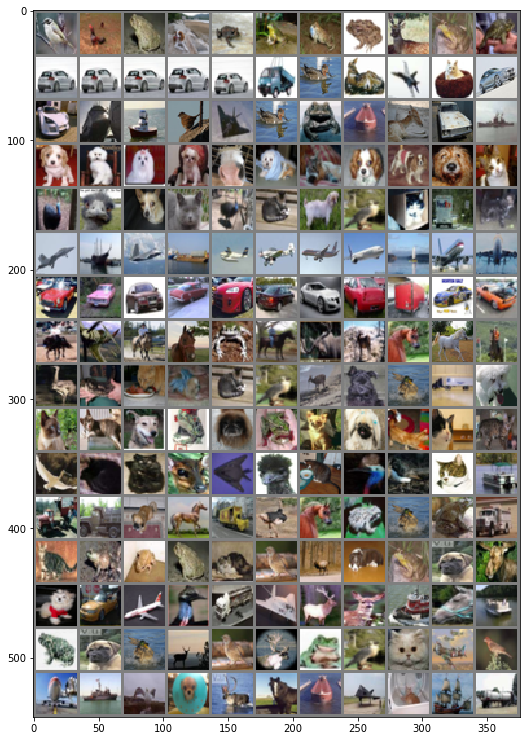

[[ 34.  35.  35.  35.  36.  36.  37.  37.  37.  37.]
 [ 20.  22.  26.  31.  32.  32.  32.  32.  32.  33.]
 [ 19.  24.  24.  25.  25.  25.  26.  27.  27.  27.]
 [ 43.  46.  46.  48.  48.  49.  51.  51.  51.  52.]
 [ 22.  24.  24.  24.  25.  25.  25.  25.  25.  26.]
 [ 36.  36.  40.  40.  41.  41.  41.  41.  42.  42.]
 [ 45.  46.  47.  47.  47.  47.  47.  47.  47.  47.]
 [ 22.  23.  27.  28.  28.  28.  29.  29.  30.  30.]
 [ 13.  14.  14.  14.  14.  15.  15.  15.  15.  15.]
 [ 29.  30.  31.  31.  31.  31.  32.  32.  32.  32.]
 [ 31.  32.  33.  34.  34.  35.  35.  35.  35.  35.]
 [ 21.  21.  22.  23.  23.  24.  24.  24.  24.  24.]
 [ 21.  22.  23.  23.  25.  25.  25.  25.  25.  25.]
 [ 29.  30.  30.  31.  31.  31.  31.  31.  31.  32.]
 [ 12.  13.  13.  14.  14.  14.  14.  14.  14.  15.]
 [ 30.  31.  32.  32.  32.  33.  33.  34.  34.  34.]]
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.578401
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.208371
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.000744
Train E

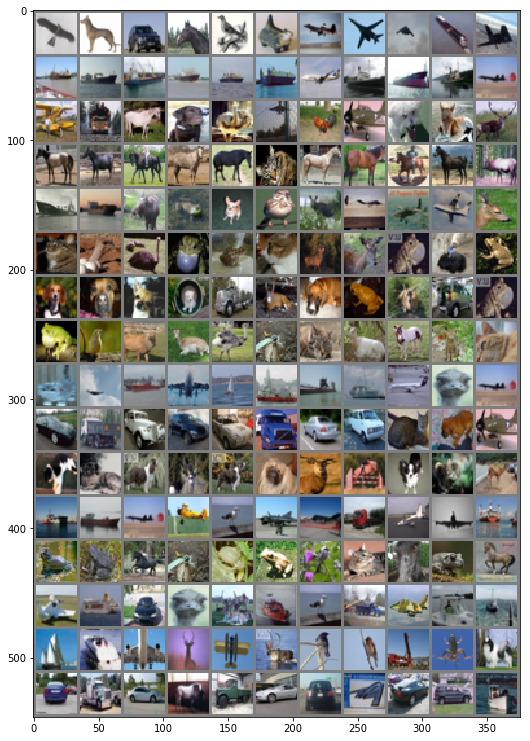

[[ 51.  55.  56.  58.  58.  59.  60.  60.  60.  60.]
 [ 30.  33.  34.  37.  39.  39.  39.  40.  40.  40.]
 [ 41.  41.  42.  45.  45.  46.  47.  47.  48.  48.]
 [ 43.  47.  48.  50.  50.  50.  50.  51.  51.  51.]
 [ 36.  36.  40.  40.  40.  40.  40.  41.  41.  41.]
 [ 32.  38.  38.  40.  40.  40.  40.  40.  40.  40.]
 [ 53.  56.  58.  59.  59.  59.  59.  59.  60.  60.]
 [ 47.  50.  51.  51.  51.  51.  51.  52.  52.  52.]
 [ 45.  46.  46.  47.  47.  48.  48.  48.  49.  50.]
 [ 43.  46.  48.  49.  49.  50.  50.  51.  51.  51.]
 [ 46.  50.  52.  53.  53.  53.  54.  55.  55.  56.]
 [ 24.  25.  26.  27.  27.  28.  28.  29.  29.  29.]
 [ 52.  56.  56.  58.  58.  58.  59.  59.  59.  60.]
 [ 35.  37.  37.  37.  38.  38.  38.  39.  39.  40.]
 [ 55.  56.  57.  57.  58.  58.  59.  60.  62.  63.]
 [ 42.  42.  43.  44.  44.  45.  46.  46.  46.  47.]]
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.723153
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.119156
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.841624
Train E

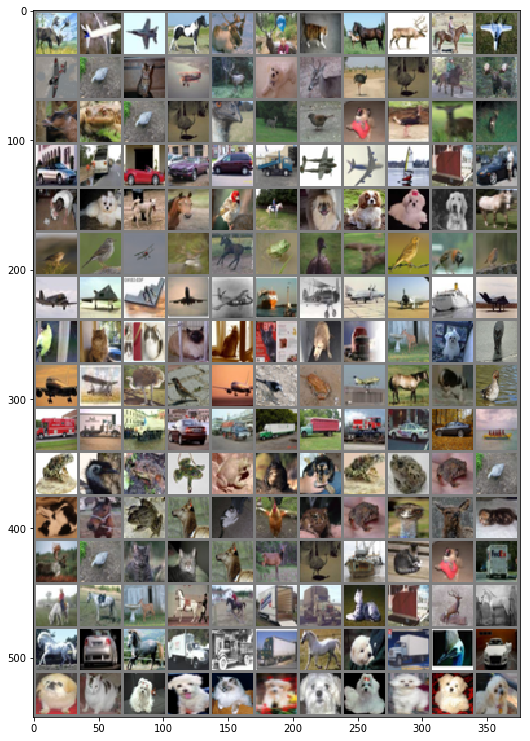

[[ 56.  60.  61.  61.  61.  62.  62.  62.  63.  63.]
 [ 34.  38.  40.  40.  41.  41.  41.  41.  42.  42.]
 [ 38.  38.  39.  39.  40.  40.  41.  42.  42.  43.]
 [ 57.  60.  60.  61.  62.  64.  64.  65.  65.  65.]
 [ 46.  54.  55.  55.  56.  56.  56.  56.  57.  57.]
 [ 32.  33.  34.  34.  36.  36.  37.  37.  38.  39.]
 [ 46.  46.  47.  47.  48.  48.  48.  49.  49.  50.]
 [ 52.  58.  58.  59.  59.  62.  63.  63.  63.  64.]
 [ 48.  49.  52.  53.  54.  56.  56.  56.  56.  56.]
 [ 57.  59.  59.  59.  60.  62.  64.  64.  64.  64.]
 [ 48.  50.  52.  52.  53.  54.  54.  55.  56.  56.]
 [ 48.  48.  50.  51.  51.  51.  52.  52.  53.  53.]
 [ 35.  36.  39.  39.  40.  40.  41.  41.  42.  42.]
 [ 54.  56.  58.  59.  59.  60.  61.  61.  61.  61.]
 [ 52.  56.  58.  60.  60.  60.  61.  62.  62.  62.]
 [ 53.  66.  69.  70.  72.  73.  74.  75.  76.  77.]]
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.687492
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.892594
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.831748
Train E

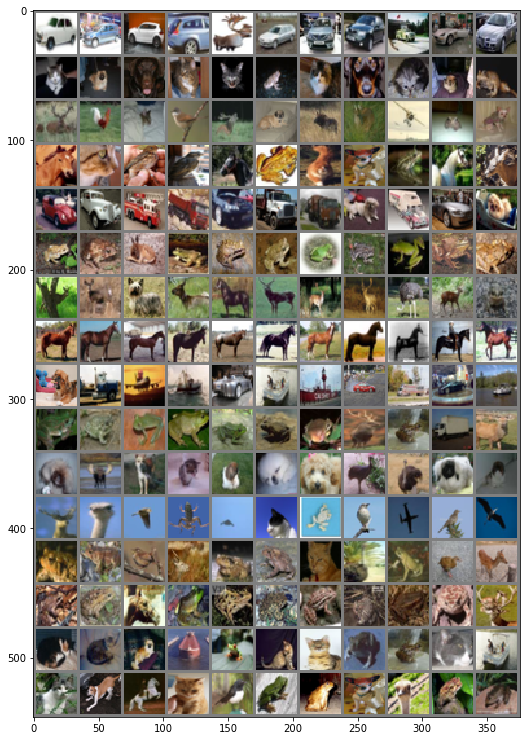

[[ 65.  71.  73.  75.  75.  75.  76.  76.  76.  77.]
 [ 58.  66.  67.  67.  71.  71.  71.  72.  72.  73.]
 [ 49.  53.  54.  54.  54.  55.  56.  57.  57.  57.]
 [ 67.  77.  78.  79.  79.  79.  80.  81.  82.  82.]
 [ 77.  80.  81.  83.  83.  85.  85.  85.  85.  85.]
 [ 57.  66.  70.  70.  70.  71.  71.  72.  72.  72.]
 [ 57.  59.  60.  61.  62.  63.  64.  65.  65.  65.]
 [ 67.  68.  70.  71.  73.  73.  73.  75.  75.  76.]
 [ 70.  72.  72.  75.  76.  77.  77.  79.  79.  80.]
 [ 49.  51.  54.  54.  56.  58.  58.  59.  59.  59.]
 [ 57.  63.  64.  65.  65.  65.  66.  67.  67.  68.]
 [ 67.  70.  73.  75.  75.  76.  77.  78.  78.  79.]
 [ 66.  68.  69.  70.  72.  73.  74.  74.  74.  74.]
 [ 83.  91.  93.  93.  95.  95.  95.  95.  96.  97.]
 [ 64.  70.  72.  73.  74.  77.  77.  78.  78.  78.]
 [ 62.  63.  65.  68.  68.  69.  69.  69.  69.  70.]]
Train Epoch: 6 [0/50000 (0%)]	Loss: 0.319555
Train Epoch: 6 [6400/50000 (13%)]	Loss: 0.829206
Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.942897
Train E

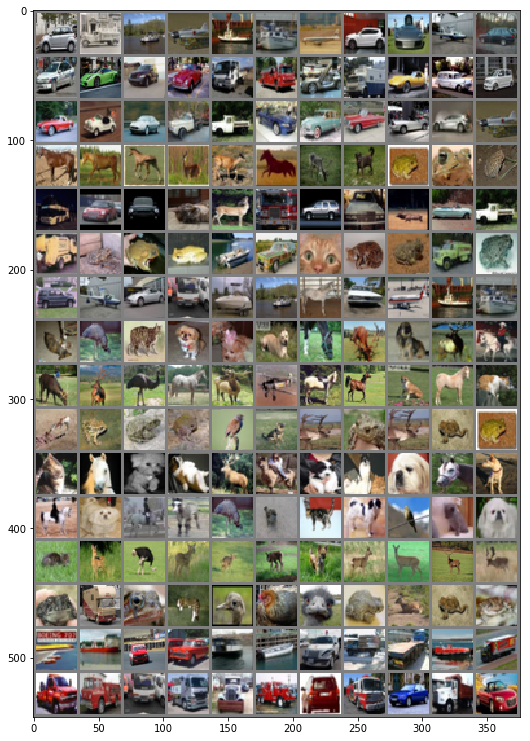

[[  60.   66.   66.   66.   67.   68.   68.   68.   70.   70.]
 [  64.   77.   77.   77.   78.   78.   79.   79.   79.   81.]
 [  72.   74.   78.   80.   81.   81.   82.   82.   83.   83.]
 [  65.   70.   71.   73.   73.   74.   75.   75.   75.   76.]
 [  62.   64.   65.   68.   69.   69.   69.   71.   71.   73.]
 [  63.   67.   67.   68.   68.   68.   69.   69.   70.   70.]
 [  58.   61.   65.   66.   66.   67.   67.   68.   68.   69.]
 [  67.   68.   68.   69.   72.   72.   73.   74.   75.   75.]
 [  63.   64.   64.   66.   69.   70.   70.   70.   70.   71.]
 [  61.   62.   62.   62.   63.   63.   64.   64.   64.   65.]
 [  85.   91.   94.   94.   97.   98.   98.   99.  100.  100.]
 [  80.   81.   81.   82.   83.   85.   85.   86.   86.   86.]
 [  50.   55.   58.   60.   61.   61.   62.   62.   63.   63.]
 [  60.   63.   64.   64.   67.   67.   68.   68.   68.   68.]
 [  81.   88.   90.   90.   91.   91.   94.   95.   95.   97.]
 [  82.   85.   86.   86.   87.   90.   91.   92.   93.

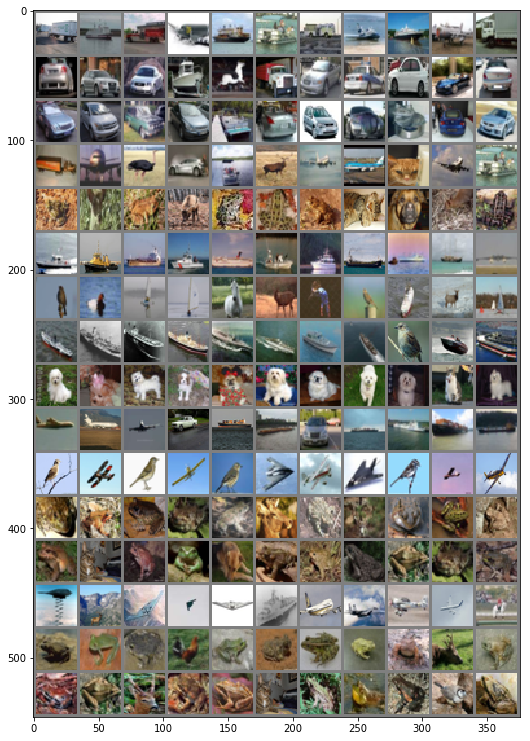

[[  75.   76.   76.   77.   77.   79.   80.   81.   81.   81.]
 [  77.   77.   77.   78.   79.   83.   83.   84.   84.   84.]
 [  75.   80.   83.   83.   86.   87.   88.   89.   90.   90.]
 [  58.   61.   62.   66.   67.   68.   69.   69.   70.   70.]
 [  93.   95.   99.  100.  103.  103.  103.  104.  104.  104.]
 [  57.   61.   63.   69.   71.   73.   73.   74.   74.   75.]
 [  84.   89.   89.   91.   92.   92.   92.   92.   94.   94.]
 [  74.   80.   80.   82.   82.   84.   86.   88.   91.   94.]
 [  85.   88.   88.   89.   90.   90.   91.   91.   91.   91.]
 [  69.   70.   73.   74.   78.   81.   81.   81.   82.   83.]
 [  69.   73.   76.   76.   77.   77.   80.   80.   80.   81.]
 [  86.   90.   95.   95.   95.   97.   97.   97.   98.   98.]
 [  80.   82.   82.   83.   84.   84.   85.   87.   87.   87.]
 [  83.   85.   85.   88.   90.   91.   92.   92.   92.   92.]
 [  67.   69.   70.   70.   70.   70.   71.   72.   73.   73.]
 [  90.   91.   92.   94.   95.   95.   97.  100.  100.

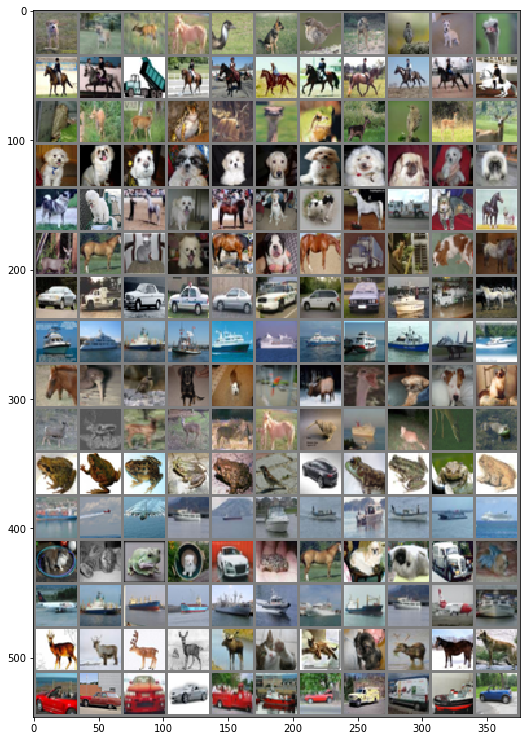

[[  65.   67.   67.   69.   70.   71.   71.   71.   72.   72.]
 [ 109.  112.  115.  116.  116.  117.  117.  118.  118.  118.]
 [  65.   79.   80.   82.   83.   83.   84.   85.   86.   86.]
 [  79.   83.   86.   87.   88.   89.   91.   91.   92.   92.]
 [  99.  103.  103.  104.  104.  104.  105.  107.  107.  107.]
 [  83.   87.   88.   88.   89.   90.   90.   90.   90.   91.]
 [  75.   80.   80.   81.   84.   84.   84.   86.   87.   87.]
 [  68.   71.   71.   73.   74.   78.   78.   79.   82.   83.]
 [  77.   77.   81.   82.   83.   83.   84.   85.   86.   87.]
 [  61.   64.   64.   64.   66.   67.   68.   68.   68.   68.]
 [  86.   89.   89.   92.   93.   94.   94.   95.   98.  100.]
 [  58.   75.   75.   75.   75.   75.   79.   79.   80.   80.]
 [  86.   89.   94.   96.   97.   97.   98.   98.   99.  100.]
 [  70.   73.   74.   74.   74.   74.   75.   75.   75.   76.]
 [  93.   96.  102.  105.  106.  109.  109.  110.  112.  112.]
 [  91.   98.   99.  100.  100.  101.  104.  104.  104.

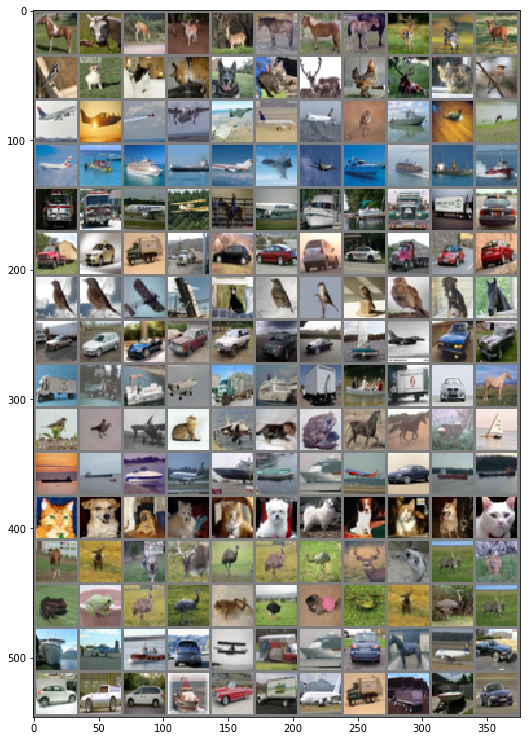

[[  67.   68.   69.   69.   70.   70.   70.   72.   73.   74.]
 [  92.   92.   94.   95.   96.   96.   98.   98.   99.   99.]
 [  80.   81.   85.   85.   89.   91.   92.   92.   93.   94.]
 [  74.   79.   80.   81.   81.   83.   84.   85.   85.   87.]
 [  83.   84.   84.   85.   87.   87.   87.   87.   88.   89.]
 [  90.   91.   91.   91.   92.   92.   93.   93.   93.   94.]
 [ 101.  102.  103.  105.  107.  108.  108.  108.  114.  115.]
 [  77.   80.   81.   81.   85.   87.   87.   87.   88.   89.]
 [  73.   76.   76.   78.   78.   80.   81.   82.   82.   83.]
 [  80.   81.   88.   89.   90.   91.   91.   91.   91.   92.]
 [  81.   85.   88.   89.   90.   90.   90.   91.   91.   91.]
 [  94.  100.  102.  102.  104.  105.  106.  107.  107.  108.]
 [  48.   54.   55.   57.   58.   59.   59.   61.   62.   63.]
 [  64.   64.   65.   66.   67.   67.   68.   68.   68.   68.]
 [  81.   86.   87.   87.   88.   89.   90.   91.   91.   93.]
 [  79.   80.   83.   85.   86.   86.   87.   87.   88.

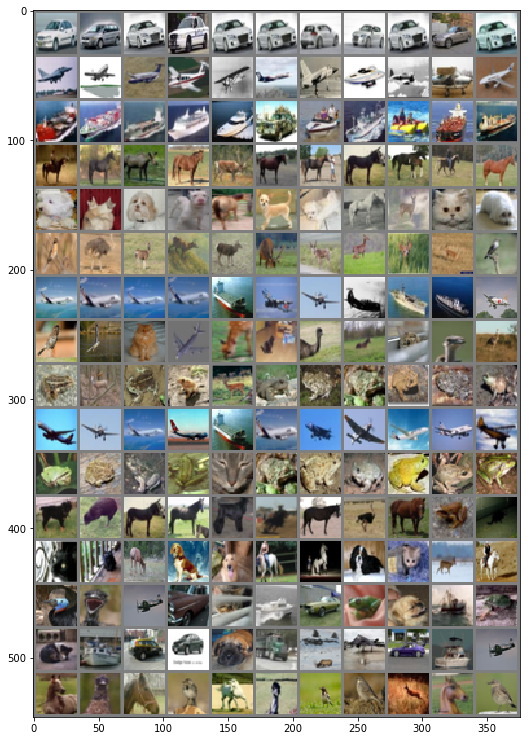

[[  98.   99.   99.  100.  101.  104.  105.  105.  105.  105.]
 [  88.   89.   92.   92.   94.   95.   95.   95.   96.   96.]
 [  78.   91.   98.  103.  104.  104.  105.  105.  107.  108.]
 [  77.   78.   86.   86.   88.   90.   90.   90.   90.   90.]
 [  96.   98.   98.   99.  102.  102.  103.  104.  104.  104.]
 [  76.   79.   82.   82.   83.   83.   84.   84.   84.   85.]
 [  63.   64.   79.   93.   95.   97.   97.   99.   99.  101.]
 [  87.   88.   93.   94.   95.   98.   99.   99.  100.  101.]
 [  90.   91.   91.   91.   94.   94.   94.   94.   94.   95.]
 [  99.  106.  106.  107.  111.  112.  112.  112.  112.  114.]
 [  98.   99.   99.   99.  100.  101.  101.  101.  102.  102.]
 [  80.   80.   80.   85.   89.   91.   91.   93.   94.   95.]
 [ 100.  104.  104.  105.  105.  106.  107.  107.  108.  109.]
 [  91.   91.   92.   93.   93.   93.   93.   95.   96.   96.]
 [  80.   82.   86.   88.   89.   93.   94.   94.   95.   95.]
 [ 101.  104.  107.  108.  108.  109.  110.  111.  111.

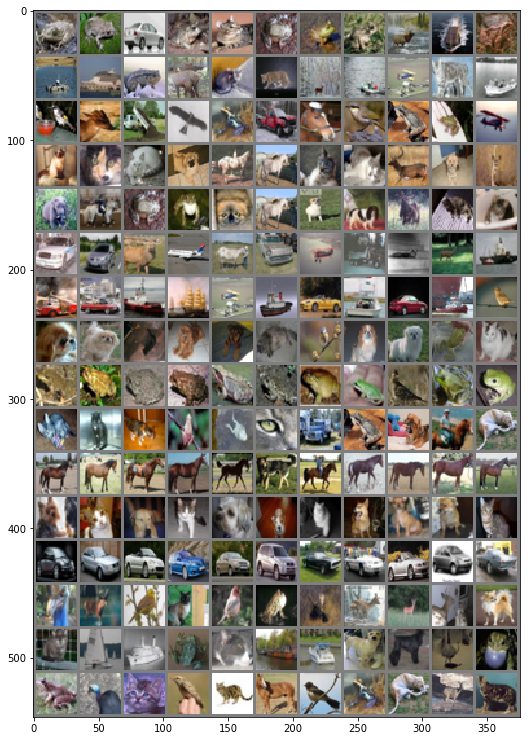

[[ 101.  101.  103.  103.  103.  103.  104.  104.  105.  106.]
 [ 110.  110.  111.  113.  113.  113.  114.  114.  114.  115.]
 [ 112.  114.  115.  115.  118.  118.  119.  120.  120.  121.]
 [  89.   89.   92.   92.   93.   94.   94.   94.   96.   96.]
 [ 103.  109.  109.  109.  111.  112.  113.  113.  114.  114.]
 [  74.   82.   83.   83.   84.   84.   86.   86.   87.   88.]
 [ 107.  109.  110.  113.  114.  114.  115.  115.  115.  116.]
 [  90.   95.   96.   97.   98.   99.   99.  100.  101.  101.]
 [  69.   78.   79.   80.   81.   81.   81.   82.   83.   85.]
 [ 120.  121.  121.  121.  122.  122.  123.  123.  124.  125.]
 [  79.   84.   88.   89.   90.   90.   91.   91.   93.   93.]
 [  93.   98.   99.  101.  101.  101.  101.  104.  105.  105.]
 [ 106.  108.  109.  109.  113.  114.  116.  116.  117.  118.]
 [  98.   98.  101.  102.  103.  105.  107.  107.  108.  108.]
 [  88.   89.   93.   93.   93.   95.   95.   95.   96.   96.]
 [ 106.  109.  109.  109.  110.  111.  111.  112.  112.

Process Process-74:
Process Process-73:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/queues.py", line 378, in get
    return recv()
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
    self._target(*self._args, **self._kwargs)
KeyboardI

KeyboardInterrupt: 

In [11]:
nearest_neighbours_plot()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    nearest_neighbours_plot()